# Data

In [2]:
import pandas as pd
doc2topic = pd.read_csv("doc2topic.csv")
doc2topic.set_index("doc_id",inplace=True)

emotions = pd.read_pickle("../data/emotions_compressed.pkl.gz")
emotions = emotions.join(doc2topic['topic'])

# check against aggregated emotions

emotions_agg = pd.read_csv("emotions.csv")
emotions_agg.set_index("Topic",inplace=True)
assert (emotions.groupby('topic').mean()-emotions_agg).abs().max().max() < 1e-4

/tmp/ipykernel_1386535/1161005462.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Insights

Biggest fear occurs in topics related to pandemia and the war on Ukraine.

In [3]:
emotions_agg.sort_values("fear",ascending=False).head(6)

,sadness,disgust,pessimism,anger,anticipation,joy,fear,optimism,surprise,trust,love
Topic,,,,,,,,,,,
2,0.072572,0.283825,0.068204,0.258969,0.404288,0.137749,0.481284,0.214518,0.073049,0.064235,0.010926
56,0.112782,0.396744,0.080592,0.362464,0.350235,0.105353,0.478799,0.155787,0.081483,0.047406,0.008637
61,0.208532,0.239893,0.145550,0.179963,0.376131,0.147433,0.404765,0.337837,0.057601,0.074166,0.011487
99,0.144684,0.170082,0.085544,0.125447,0.389993,0.317713,0.328546,0.398602,0.064985,0.065424,0.023875
60,0.226947,0.312838,0.135836,0.255518,0.375404,0.190973,0.275193,0.305734,0.075159,0.069927,0.015099
19,0.082476,0.198030,0.072334,0.182618,0.507511,0.299126,0.254994,0.446743,0.073088,0.127018,0.021420


Note that the standard deviations within clusters are huge.

In [4]:
emotions_agg_mu = emotions.groupby("topic").median().round(3)
emotions_agg_std = emotions.groupby("topic").std().round(3)

pd.concat([emotions_agg_mu.astype(str),emotions_agg_std.astype(str)]).groupby("topic").agg(lambda s: '+'.join(map(str,s))).loc[[60,61,99]]

,sadness,disgust,pessimism,anger,anticipation,joy,fear,optimism,surprise,trust,love
topic,,,,,,,,,,,
60,0.103+0.267,0.175+0.304,0.091+0.133,0.102+0.294,0.367+0.236,0.052+0.267,0.146+0.287,0.166+0.312,0.051+0.073,0.034+0.084,0.006+0.039
61,0.097+0.243,0.123+0.256,0.102+0.129,0.068+0.239,0.38+0.214,0.046+0.223,0.335+0.312,0.205+0.32,0.042+0.057,0.036+0.088,0.006+0.027
99,0.053+0.212,0.087+0.212,0.047+0.102,0.053+0.191,0.398+0.211,0.193+0.311,0.273+0.278,0.363+0.304,0.05+0.056,0.043+0.068,0.008+0.069


This is partly because emotion distributions are not only skewed but also multimodal.

<Axes: ylabel='Frequency'>

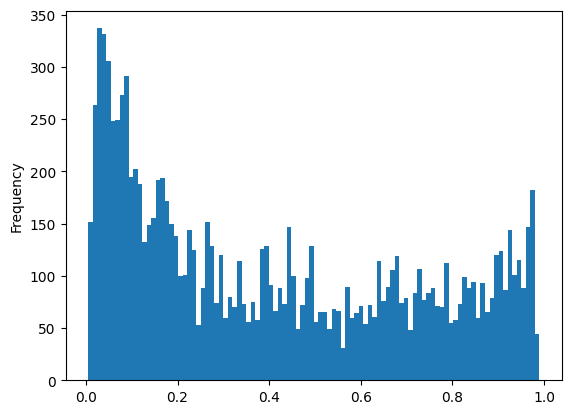

In [5]:
mask = emotions['topic']==61

emotions.loc[mask,'fear'].plot(kind='hist',bins=100)

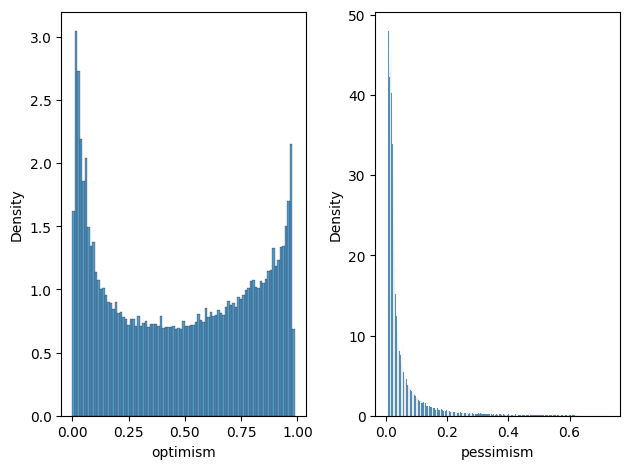

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

fig,axs = plt.subplots(1,2)

ax = axs[0]
sns.histplot(emotions['optimism'],stat='density',ax=ax,label='optimism')

ax = axs[1]
sns.histplot(emotions['pessimism'],stat='density',ax=ax,label='pessimism')

plt.tight_layout()

In [37]:
cols = set(emotions_agg_mu.columns)
cols.remove("optimism")
cols.remove("pessimism")
cols.remove("love")
cols = list(cols)

cols = ['fear','anger','disgust', 'sadness', 'anticipation', 'surprise', 'joy', 'trust']

emotions_agg_dominant = emotions_agg_mu.loc[:,cols].idxmax(1)
emotions_agg_dominant = emotions_agg_dominant.value_counts()

In [20]:
emotion_colors = {
    'joy': 'gold',
    'trust': 'olivedrab',
    'fear': 'forestgreen',
    'surprise': 'skyblue',
    'sadness': 'dodgerblue',
    'disgust': 'slateblue',
    'anger': 'orangered',
    'anticipation': 'darkorange',
    'optimism': 'orange', # between dark orange and gold
    'pessimism': 'cornflowerblue', # between slateblue and dodgerblue
    'love':'golden olive',
}

# based on https://www.tsw.co.uk/blog/leadership-and-management/plutchik-emotion-wheel/

## Dominant Emotions

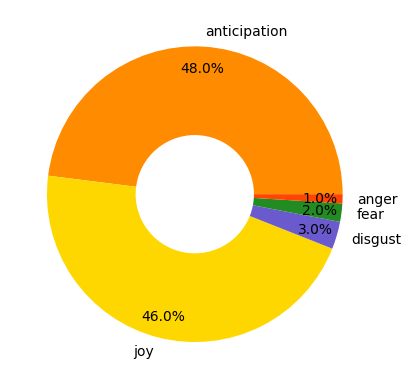

In [18]:
fig,ax = plt.subplots()

plt.pie(emotions_agg_dominant.values,
        labels=emotions_agg_dominant.index, 
        colors = emotions_agg_dominant.index.map(emotion_colors.get), 
        autopct='%1.1f%%', 
        pctdistance=0.85
)
# Add a white circle at the center to create the donut effect
centre_circle = plt.Circle((0, 0), 0.40, fc='white')

fig = plt.gcf()
fig.gca().add_artist(centre_circle)

#plt.title('Employee Salary Details')
plt.show()

fig.savefig("dominant_emotions.svg",transparent=True)

In [38]:
emotions_agg_dominant#[emotions_agg_dominant=="anger"]

anticipation    48
joy             46
disgust          3
fear             2
anger            1
Name: count, dtype: int64

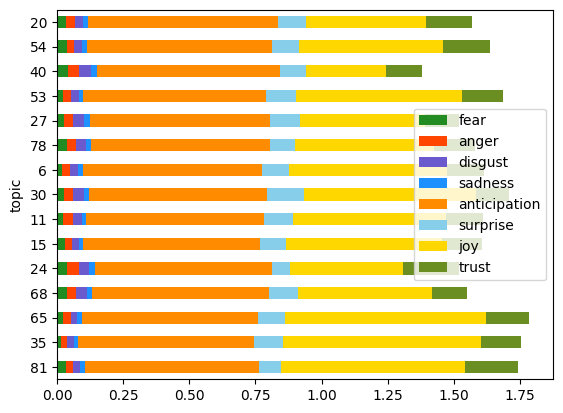

In [42]:
N_TOP = 15

df = emotions_agg_mu.sort_values("anticipation",ascending=False).head(N_TOP)

df.columns = df.columns.astype("category")
df.loc[:,cols]

fig,ax = plt.subplots()
df.loc[:,cols].plot(kind="barh",stacked=True,ax=ax,color=emotion_colors)
ax.invert_yaxis()
plt.show()

fig.savefig("top_anticipating_emotions.svg", transparent=False)

## Pessimism / Optimism

Let's analyse optimism and pessimism but approximate them from Plutchik’s “wheel of emotions”.

In [12]:
pessimism = 0.5*emotions["anticipation"] + 0.5*emotions["sadness"]# - emotions["anticipation"] * emotions["sadness"]
optimism = 0.5*emotions["anticipation"] + 0.5*emotions["joy"]# - emotions["anticipation"] * emotions["joy"]
emotions_corr = pd.DataFrame({"pessimism":pessimism,"optimism":optimism,"topic":emotions["topic"]})
emotions_corr["diff"] = emotions_corr["optimism"] - emotions_corr["pessimism"]
emotions_corr["topic"] = emotions_corr["topic"].astype("category")

In [13]:
import pandas as pd

data = {
    'Cluster': list(range(1, 22)),
    'Topics': [
        [35, 6, 54, 20, 53, 40, 27],
        [91, 50, 58],
        [97, 29],
        [71, 65, 0, 93, 79, 87],
        [68, 92],
        [60, 61, 99],
        [78, 88, 30, 11, 70],
        [47, 15, 46],
        [14, 10, 81, 43, 62, 37, 21, 33],
        [26, 18, 76, 38, 22, 32, 67, 98, 82],
        [44, 5, 52, 64],
        [19, 2, 56],
        [74, 80, 31, 24],
        [9, 94, 95, 51],
        [48, 73, 23, 39, 42],
        [59, 89, 1, 96, 17],
        [85, 45, 63],
        [75, 84, 36, 55, 3],
        [77, 66, 4, 25, 8],
        [41, 83, 69, 13, 86, 90, 49, 28],
        [57, 12, 16, 7, 72, 34]
    ],
    'Leitmotiv': [
        'AI, ML, DL, Big Data, NLP',
        'Entertainment and Gaming',
        'Fashion and Lifestyle',
        'AV, Automatic Industry, EV, Eco-energy, Innovative engineering, Drones, Space',
        'Healthcare, AI',
        'Covid-19 and Quarantine',
        'Automation, Robots Engineering, Robotics, Autonomous Robots, AI',
        'IoT, 5G, Security, Digital Transformation, Industry 4.0, Edge Computing',
        'Quantum Computing, Data Analytics, Digital Transformation, Tech Innovations, Metaverse',
        'Women in Tech, Social Media, Payments, Retail, Privacy, Security',
        'Start-up, Fintech, Cyrptocurrency',
        'Cybersecurity, War, Ukraine',
        'CX, UX, Future of Claims, Insurtech',
        'Future of Work, Future of Leaders, Leadership of Change, Strategy, Management',
        'AI, Data Science, AV, VR, Digital Transformation, Metaverse',
        'Gratitude (Thanks, Acknowledgements)',
        'Appreciation (Thanks, Great)',
        'Mathematics, Life, Questioning',
        'Time Reflections (Year, Mypov, Women in History)',
        'Politics, Policies, Ukraine War, Social Media',
        'Future, Economics, Education, People Skills, Collaborative Enterprise, Climate, Teamwork'
    ]
}

topic2cluster = pd.DataFrame(data)

topics_to_cluster = {}
for index, row in topic2cluster.iterrows():
    cluster = row['Cluster']
    topics = row['Topics']
    for topic in topics:
        topics_to_cluster[topic] = cluster

topic2cluster = topic2cluster.explode("Topics")
topic2cluster.set_index("Topics",inplace=True)
#topics_to_cluster

/tmp/ipykernel_1356487/3595401913.py:22: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


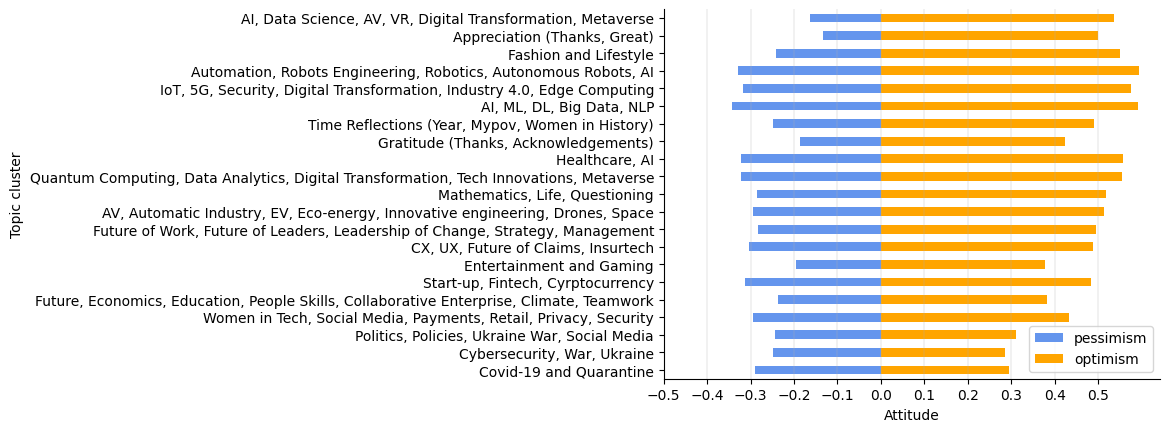

In [20]:
import numpy as np


fig,ax = plt.subplots()

cluster = emotions_corr["topic"].map(topics_to_cluster.get)
attitude_agg = emotions_corr[["pessimism","optimism"]].groupby(cluster).mean()
attitude_agg["pessimism"] = -attitude_agg["pessimism"]
diff = attitude_agg["optimism"] + attitude_agg["pessimism"]
attitude_agg=attitude_agg.loc[diff.sort_values().index]
attitude_agg.index = attitude_agg.index.map(topic2cluster.set_index("Cluster")["Leitmotiv"].to_dict().get)


attitude_agg.plot(kind='barh',stacked=True,ax=ax,color=emotion_colors)
ax.grid(axis="x",which="major",linewidth=0.25)
ax.set_xticks(np.arange(-0.5,0.6,0.1,))
ax.set_ylabel("Topic cluster")
ax.set_xlabel("Attitude")
ax.spines[['right', 'top']].set_visible(False)

fig.savefig("attitude.svg")
plt.tight_layout()
plt.show()
#ax.bar_label(p, label_type='center')

/tmp/ipykernel_1356487/2578675772.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  y = emotions_df.groupby("topic")[kpi].mean()
/tmp/ipykernel_1356487/2578675772.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  error = emotions_df.groupby("topic")[kpi].std()


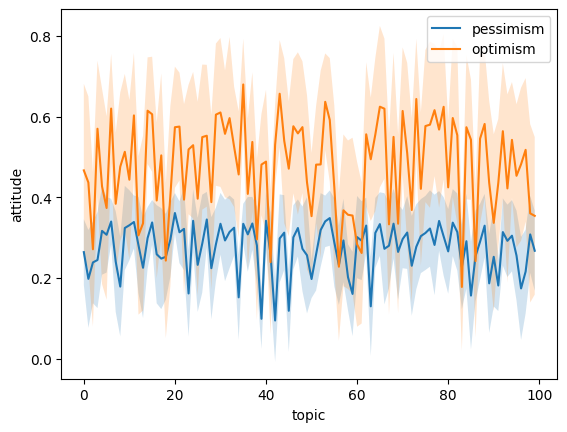

In [17]:
import matplotlib.pyplot as plt

emotions_df = emotions_corr

fig,ax = plt.subplots()
for kpi in ["pessimism", "optimism"]:
    y = emotions_df.groupby("topic")[kpi].mean()
    error = emotions_df.groupby("topic")[kpi].std()
    ax.plot(y,label=kpi)
    ax.fill_between(y.index,y-error, y+error,alpha=0.2)

ax.set_xlabel("topic")
ax.set_ylabel("attitude")
ax.legend()
#plt.title("*Optimism and pessimism were approximated from anticipation, sadness and joy.")
plt.show()

All topics have positive mean sentiment, perhaps except one topic about the war...

In [18]:
from scipy.stats import ttest_ind

pvals = {}

emotions_df = emotions_corr

for topic,idxs in emotions.groupby("topic").groups.items():
    x = emotions_df.loc[idxs,"optimism"]
    y = emotions_df.loc[idxs,"pessimism"]
    pval = ttest_ind(x,y,equal_var=False).pvalue
    pvals[topic] = pval

pvals = pd.Series(pvals)
pvals.sort_values(ascending=False).head()
#emotions[["optimism","pessimism","topic"]].groupby("topic").groups

56    1.906642e-02
18    4.610388e-09
38    2.717394e-11
86    3.059999e-12
60    8.218752e-18
dtype: float64